## Import dependancies


In [1]:
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import data.make_dataset as make_dataset
import visualization.visualize as visualize
import features.build_features as build_features

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Prevent excessive memory usage
DRAW_PLOTS = False

## Prepare data loading : set correct variable types


In [2]:
# Read column names
column_names = pd.read_csv(
    "../data/processed/application_train.csv", nrows=0
).columns.values

# Set column types according to fields description (../data/raw/HomeCredit_columns_description.csv)
column_types = {
    col: "category"
    for col in column_names
    if col.startswith(("NAME_",))
    or col.endswith(("_TYPE"))
    or col
    in [
        "CODE_GENDER",
        "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE",
        "HOUSETYPE_MODE",
        "WALLSMATERIAL_MODE",
        "EMERGENCYSTATE_MODE",
    ]
}
column_types |= {
    col: bool
    for col in column_names
    if col.startswith(("FLAG_", "REG_", "LIVE_"))
}


## Application and Test data loading and first observations


### Application training data


In [3]:
# Load application data
app_train_df = pd.read_csv(
    "../data/processed/application_train.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"],
)

# Application data features
app_train_df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,False,True,0,135000.0,312682.5,29686.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,False,True,0,121500.0,513000.0,21865.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Application data columns info
app_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(9)
memory usage: 187.7 MB


In [5]:
# Application data variables description
app_train_df.describe(include="all")


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307507,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511,307511,307511,307511,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,2,2,2,NaN,NaN,NaN,NaN,...,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,False,True,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,305011,307328,307355,307408,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,NaN,NaN,NaN,NaN,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,NaN,NaN,NaN,NaN,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


### Application testing data


In [6]:
# Load test data
app_test_df = pd.read_csv(
    "../data/processed/application_test.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"],
)

# Test data features
app_test_df.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,False,True,0,135000.0,568800.0,20560.5,450000.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,False,True,0,99000.0,222768.0,17370.0,180000.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,630000.0,...,False,False,False,False,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,1575000.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,True,False,1,180000.0,625500.0,32067.0,625500.0,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Test data columns info
app_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(8)
memory usage: 29.4 MB


In [8]:
# Test data variables description
app_test_df.describe(include="all")


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,...,48744,48744,48744,48744,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,False,True,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48305,32678,32311,33658,NaN,NaN,NaN,NaN,NaN,...,48668,48744,48744,48744,NaN,NaN,NaN,NaN,NaN,NaN
mean,277796.676350,NaN,NaN,NaN,NaN,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,...,NaN,NaN,NaN,NaN,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,NaN,NaN,NaN,NaN,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,...,NaN,NaN,NaN,NaN,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,NaN,NaN,NaN,NaN,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,NaN,NaN,NaN,NaN,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,NaN,NaN,NaN,NaN,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


## Exploratory Data Analysis (EDA)


### Look for empty columns

In [9]:
# Plot application columns emptiness ratio
if DRAW_PLOTS:
    visualize.plot_empty_values(app_train_df)


In [10]:
# Plot test columns emptiness ratio
if DRAW_PLOTS:
    visualize.plot_empty_values(app_test_df)


All variables have less than 70% of empty values, which is considered enough for imputation.

### Look for impossible values and outliers


In [11]:
# Remove values that are outside possible range
data_constraints = {
    "AMT_INCOME_TOTAL": {"min": 0, "max": 20 * 1000 * 1000,},
    "DAYS_EMPLOYED": {"min": -100 * 365, "max": 0,},
    "AMT_REQ_CREDIT_BUREAU_QRT": {"min": 0, "max": 20,},
    "OBS_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
    "DEF_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
    "OBS_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
    "DEF_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
}

clean_app_train_df = build_features.drop_impossible_values(
    app_train_df, constraints=data_constraints,
)

# Remove values that are statistically unlikely
clean_app_train_df = build_features.drop_outliers(
    clean_app_train_df, columns=["REGION_POPULATION_RELATIVE"],
)

# Draw the BoxPlots of some numeric columns, split per Target
columns_to_plot = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "OWN_CAR_AGE",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_LAST_PHONE_CHANGE",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
]
if DRAW_PLOTS:
    visualize.plot_boxes(
        dataframe=clean_app_train_df,
        plot_columns=columns_to_plot,
        categorical_column="TARGET",
    )


In [12]:
# Remove values that are outside possible range
clean_app_test_df = build_features.drop_impossible_values(
    app_test_df,
    constraints=data_constraints,
)

# Remove values that are statistically unlikely 
clean_app_test_df = build_features.drop_outliers(
    clean_app_test_df, columns=["REGION_POPULATION_RELATIVE"],
)


### Look at categorical variables


In [13]:
if DRAW_PLOTS:
    # Draw the Bar charts of some categorical columns, split per Target
    visualize.plot_categories_bars(
        clean_app_train_df,
        plot_columns=[
            "NAME_CONTRACT_TYPE",
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "FLAG_MOBIL",
        ],
        categorical_column="TARGET",
    )


#### One Hot Encoding

No ordinal data => One Hot Encoding is better than Label Encoding


In [14]:
# One-hot encoding of categorical variables
encoded_app_train_df = pd.get_dummies(clean_app_train_df, dtype=bool)
encoded_app_test_df = pd.get_dummies(clean_app_test_df, dtype=bool)

train_labels = encoded_app_train_df["TARGET"]

# Align the training and testing data, keep only columns present in both dataframes
encoded_app_train_df, encoded_app_test_df = encoded_app_train_df.align(
    encoded_app_test_df, join="inner", axis=1
)

# Add the target back in
encoded_app_train_df["TARGET"] = train_labels

print("Training Features shape: ", encoded_app_train_df.shape)
print("Testing Features shape: ", encoded_app_test_df.shape)


Training Features shape:  (217560, 240)
Testing Features shape:  (34522, 239)


### Missing values imputation


In [15]:
# If imputed data already exist, load from CSV
# Else, do the imputation and save the data to CSV
if os.path.exists("../data/processed/imputed_application_train.csv"):
    imputed_app_train_df = pd.read_csv(
        "../data/processed/imputed_application_train.csv", index_col=0
    )
else:
    imputed_app_train_df = build_features.impute_missing_values(
        encoded_app_train_df
    )
    imputed_app_train_df.to_csv("../data/processed/imputed_application_train.csv")


if os.path.exists("../data/processed/imputed_application_test.csv"):
    imputed_app_test_df = pd.read_csv(
        "../data/processed/imputed_application_test.csv", index_col=0
    )
else:
    imputed_app_test_df = build_features.impute_missing_values(
        encoded_app_test_df
    )
    imputed_app_test_df.to_csv("../data/processed/imputed_application_test.csv")


#### Features selection

Variables that are not highly correlated to an other, and at least a bit correlated to TARGET.

In [16]:
# Let's compute the correlation matrix
corrs_app_train_df = imputed_app_train_df.corr()

if DRAW_PLOTS:
    fig = px.imshow(corrs_app_train_df,
        title="Correlations between features",
        width=1200,
        height=1200,
    )
    fig.show()

In [17]:
# Let's drop variables that are highly de-correlated from TARGET

simple_app_train_df = imputed_app_train_df.copy()
simple_app_test_df = imputed_app_test_df.copy()

highly_decorrelated_from_target_columns = pd.Series({})
for col in corrs_app_train_df.columns:
    if col != "TARGET" and (
        pd.isnull(corrs_app_train_df[col]["TARGET"])
        or abs(corrs_app_train_df[col]["TARGET"]) < 0.01
    ):
        highly_decorrelated_from_target_columns[col] = corrs_app_train_df[col][
            "TARGET"
        ]

print(highly_decorrelated_from_target_columns.sort_values())


FLAG_DOCUMENT_18                           -0.009944
FONDKAPREMONT_MODE_reg oper spec account   -0.009391
ORGANIZATION_TYPE_Other                    -0.009310
ORGANIZATION_TYPE_University               -0.009205
NAME_TYPE_SUITE_Family                     -0.009086
                                              ...   
CNT_CHILDREN                                0.007920
ORGANIZATION_TYPE_Industry: type 3          0.008236
FLAG_MOBIL                                       NaN
FLAG_DOCUMENT_2                                  NaN
NAME_INCOME_TYPE_Unemployed                      NaN
Length: 122, dtype: float64


<ipython-input-17-8b257840667b>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  highly_decorrelated_from_target_columns = pd.Series({})


In [18]:
# Drop irrelevant columns
simple_app_train_df.drop(
    columns=highly_decorrelated_from_target_columns.index,
    inplace=True,
    errors="ignore",
)
simple_app_test_df.drop(
    columns=highly_decorrelated_from_target_columns.index,
    inplace=True,
    errors="ignore",
)

simple_app_train_df.shape


(217560, 117)

In [19]:
# Let's drop variables that have a highly correlated pair
highly_correlated_columns = pd.DataFrame(columns=["pair", "correlation"])
for i in range(len(corrs_app_train_df.columns)):
    for j in range(i + 1, len(corrs_app_train_df.columns)):
        if i != j and abs(corrs_app_train_df.iloc[i, j]) > 0.9:
            highly_correlated_columns.loc[corrs_app_train_df.columns[i]] = [
                corrs_app_train_df.columns[j],
                corrs_app_train_df.iloc[i, j],
            ]

print(highly_correlated_columns.sort_values(by="correlation"))


                                                             pair  correlation
NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans    -1.000000
CODE_GENDER_F                                       CODE_GENDER_M    -0.999961
YEARS_BUILD_MODE                                 YEARS_BUILD_MEDI     0.904418
APARTMENTS_AVG                                    LIVINGAREA_MEDI     0.907225
APARTMENTS_MEDI                                   LIVINGAREA_MEDI     0.911790
HOUSETYPE_MODE_block of flats              EMERGENCYSTATE_MODE_No     0.913228
LIVINGAREA_MEDI                                    TOTALAREA_MODE     0.919284
FLOORSMIN_MODE                                     FLOORSMIN_MEDI     0.919737
LIVINGAREA_AVG                                     TOTALAREA_MODE     0.921020
APARTMENTS_MODE                             LIVINGAPARTMENTS_MEDI     0.931213
REGION_RATING_CLIENT                  REGION_RATING_CLIENT_W_CITY     0.949955
YEARS_BEGINEXPLUATATION_MODE         YEARS_BEGINEXPL

In [20]:

simple_app_train_df.drop(
    columns=highly_correlated_columns.index, inplace=True, errors="ignore",
)
simple_app_test_df.drop(
    columns=highly_correlated_columns.index, inplace=True, errors="ignore",
)

simple_app_train_df.shape


(217560, 87)

In [21]:
top_correlated_to_target_columns = (
    pd.Series(
        data={
            col: corrs_app_train_df[col]["TARGET"]
            for col in simple_app_train_df.columns.difference(["TARGET"])
        }
    )
    .map(abs)
    .sort_values(ascending=False)
    .head(20)
)

if DRAW_PLOTS:
    fig = px.bar(
        top_correlated_to_target_columns,
        color=top_correlated_to_target_columns.values,
        title="Top 20 Columns Correlated to Target",
        labels={
            "index": "Column name",
            "value": "Correlation",
            "color": "Correlation",
        },
        width=1200,
        height=800,
    )
    fig.show()


---
---
---
---
---

## Classification models evaluation


In [22]:
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
    mean_squared_log_error,
    median_absolute_error,
    r2_score,
    pairwise,
)

# Sample data
sample_app_train_df = simple_app_train_df.sample(frac=0.1, random_state=42)

# Let's split the data into train and test sets
X = sample_app_train_df[sample_app_train_df.columns.difference(["TARGET"])]
y = sample_app_train_df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(X_train)


X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


## Linear models


In [ ]:
# Linear Regression

# - On apprend les coefficients d'une régression linéaire en maximisant le log de la vraisemblance, où, de manière équivalente si l'on suppose l'erreur normalement distribuée et centrée en zéro, en minimisant la somme des carrés des erreurs.
# - Cette méthode s'appelle la méthode des moindres carrés.
# - Si la matrice  $\(X^\top X\)$ est inversible, la régression linéaire admet une solution unique et explicite.
# - Sinon, on peut calculer une solution grâce à un algorithme de calcul de pseudo-inverse, mais cette solution n'est pas unique.


# Variables must be :
# - linear relationship with target
# - i.i.d.
# - error is normally distributed
# - no outliers
# - no missing values
# - no multicollinearity
# - numeric (categorical variables must be encoded)


from sklearn.linear_model import LinearRegression


lr = LinearRegression()
lr.fit(X_train_std, y_train)


y_pred = lr.predict(X_test_std)


print(
    f"Best score: {lr.score(X_test_std, y_test):.4f}",
    f"R2 score: {r2_score(y_test, y_pred):.3f}, "
    f"MSE: {mean_squared_error(y_test, y_pred):.3f}, "
    f"MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
    f"EVS: {explained_variance_score(y_test, y_pred):.3f}"
)


In [ ]:
top_coefficients = pd.Series(lr.coef_, X.columns).map(abs).sort_values(ascending=False).head(20)


if DRAW_PLOTS:
    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 Columns importance",
        labels={
            "index": "Column name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()


In [ ]:
# Ridge Regression
# Prevents overfitting by penalizing the magnitude of coefficients with L2 regularization of the loss function

# - La norme ℓ2 du vecteur de poids peut être utilisée comme terme de régularisation de la régression linéaire.
# - Cela s'appelle la régularisation de Tykhonov, ou régression ridge.
# - La régression ridge admet toujours une solution analytique unique.
# - La régression ridge permet d'éviter le surapprentissage en restraignant l'amplitude des poids.
# - La régression ridge a un effet de sélection groupée : les variables corrélées ont le même coefficient.


from sklearn.linear_model import RidgeCV


clf=RidgeCV(alphas=np.logspace(-3,7,50))
clf.fit(X_train_std, y_train)


y_pred = clf.predict(X_test_std)


print(
    f"Best alpha: {clf.alpha_:.3f}, ",
    f"Best score: {clf.score(X_test_std, y_test):.3f}, ",
    f"R2 score: {r2_score(y_test, y_pred):.3f}, "
    f"MSE: {mean_squared_error(y_test, y_pred):.3f}, "
    f"MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
    f"EVS: {explained_variance_score(y_test, y_pred):.3f}"
)




In [ ]:
top_coefficients = pd.Series(clf.coef_, X.columns).map(abs).sort_values(ascending=False).head(20)


if DRAW_PLOTS:
    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 Columns importance",
        labels={
            "index": "Column name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import plotly.graph_objects as go


# #############################################################################
# Compute paths

fig = go.Figure()
alphas = np.logspace(-3,7,50)
coefficients = pd.DataFrame(index=X_train_std.columns, columns=alphas)
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train_std, y_train)
    coefficients.loc[:, a] = ridge.coef_


for col in coefficients.index:
    fig.add_trace(
        go.Scatter(
            x=alphas,
            y=coefficients.loc[col,:],
            name=col,
        )
    )


# #############################################################################
# Display results

fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Ridge coefficients as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="coefficient",
    width=1200,
    height=800,
)

fig.show()



In [ ]:
# Lasso Regression
# Lasso is a special case of Ridge regression where the penalty is L1
# Allows for sparse solutions by removing features with L1 regularization of the loss function

# - Le lasso utilise la norme ℓ1 du vecteur β comme régularisateur pour obtenir un modèle parcimonieux.
# - Le lasso peut donc être utilisé comme un algorithme de réduction de dimension supervisée.
# - Le lasso n'a pas de solution explicite, ni nécessairement unique.


from sklearn.linear_model import LassoCV, Lasso


clf=LassoCV(alphas=np.logspace(-5,3,50))
clf.fit(X_train_std, y_train)


y_pred = clf.predict(X_test_std)

print(
    f"Best alpha: {clf.alpha_:.6f}, ",
    f"Best score: {clf.score(X_test_std, y_test):.3f}, ",
    f"R2 score: {r2_score(y_test, y_pred):.3f}, "
    f"MSE: {mean_squared_error(y_test, y_pred):.3f}, "
    f"MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
    f"EVS: {explained_variance_score(y_test, y_pred):.3f}"
)


In [ ]:
top_coefficients = pd.Series(clf.coef_, X.columns).map(abs).sort_values(ascending=False).head(20)


if True or DRAW_PLOTS:
    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 Columns importance",
        labels={
            "index": "Column name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()

In [ ]:
alphas = np.logspace(-4, -1, 50)
coefficients = pd.DataFrame(index=X.columns, columns=alphas)
errors = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_std, y_train)
    coefficients.loc[:, a] = lasso.coef_
    errors.append(mean_squared_error(y_test, lasso.predict(X_test_std)))


fig = go.Figure()
for col in coefficients.index:
    fig.add_trace(go.Scatter(x=alphas, y=coefficients.loc[col, :], name=col,))

fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Lasso coefficients as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="coefficient",
    width=1200,
    height=800,
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=alphas, y=errors, name="MSE",))
fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Lasso MSE as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="MSE",
    width=1200,
    height=800,
)
fig.show()

In [ ]:
fig = go.Figure()
for col in coefficients.index:
    fig.add_trace(go.Scatter(x=alphas, y=coefficients.loc[col, :], name=col,))

fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Lasso coefficients as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="coefficient",
    width=1200,
    height=800,
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=alphas, y=errors, name="MSE",))
fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Lasso MSE as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="MSE",
    width=1200,
    height=800,
)
fig.show()


In [ ]:
# Elastic Net
# Elastic Net is a combination of Ridge and Lasso
# Prevents overfitting by penalizing the magnitude of coefficients with L2 regularization of the loss function
# Allows for sparse solutions by removing features with L1 regularization of the loss function

# - L'elastic net combine les normes ℓ1 et ℓ2 pour obtenir une solution moins parcimonieuse que le lasso, mais plus stable et dans laquelle toutes les variables corrélées pertinentes pour la prédiction de l'étiquette sont sélectionnées et reçoivent un poids identique.


from sklearn.linear_model import ElasticNetCV

alphas = np.logspace(-4, 0, 20)
l1_ratios = np.linspace(0.01, 0.99, 10)
clf = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)
clf.fit(X_train_std, y_train)


y_pred = clf.predict(X_test_std)


print(
    f"Best alpha: {clf.alpha_:.6f}, ",
    f"Best l1_ratio: {clf.l1_ratio_:.6f}, ",
    f"Best score: {clf.score(X_test_std, y_test):.3f}, ",
    f"R2 score: {r2_score(y_test, y_pred):.3f}, "
    f"MSE: {mean_squared_error(y_test, y_pred):.3f}, "
    f"MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
    f"EVS: {explained_variance_score(y_test, y_pred):.3f}",
)


top_coefficients = (
    pd.Series(clf.coef_, X.columns)
    .map(abs)
    .sort_values(ascending=False)
    .head(20)
)


if True or DRAW_PLOTS:
    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 Columns importance",
        labels={
            "index": "Column name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()


coefficients = pd.DataFrame(index=X.columns, columns=alphas)
errors = []
for a in alphas:
    elastic = linear_model.ElasticNet(alpha=a, l1_ratio=clf.l1_ratio_)
    elastic.fit(X_train_std, y_train)
    coefficients.loc[:, a] = elastic.coef_
    errors.append(mean_squared_error(y_test, elastic.predict(X_test_std)))


fig = go.Figure()
for col in coefficients.index:
    fig.add_trace(go.Scatter(x=alphas, y=coefficients.loc[col, :], name=col,))

fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="ElasticNet coefficients as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="coefficient",
    width=1200,
    height=800,
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=alphas, y=errors, name="MSE"))
fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="ElasticNet MSE as a function of the regularization",
    xaxis_title="log(alpha)",
    yaxis_title="MSE",
    width=1200,
    height=800,
)
fig.show()


In [ ]:
# Logistic Regression
#
# - La régression logistique modélise la probabilité qu'une observation appartienne à la classe positive comme une transformation logistique d'une combinaison linéaire des variables.
# - Les coefficients d'une régression logistique s'apprennent par maximisation de vraisemblance, mais il n'existe pas de solution explicite.
# - La vraisemblance est convexe, et de nombreux solveurs peuvent être utilisés pour trouver une solution numérique.
# - Les concepts de régularisation ℓ1 et ℓ2 s'appliquent aussi à la régression logistique.


## StratifiedKFold
# StratifiedKFold est un objet de type sklearn.model_selection.StratifiedKFold
# Il permet de séparer les données en nombre de folds de manière stratifiée.
# Les proportions des classes sont conservées.


from sklearn.linear_model import LogisticRegression


c_values = np.logspace(-3, 3, 10)
l1_ratios = np.linspace(0.001, 0.999, 10)

clf = GridSearchCV(
    estimator=LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        class_weight="balanced",
        random_state=42,
        verbose=2,
    ),
    param_grid={"C": c_values, "l1_ratio": l1_ratios,},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=4,
    verbose=2,
)
clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


In [ ]:
best_clf = clf.best_estimator_

top_coefficients = (
    pd.Series(best_clf.coef_[0], X.columns)
    .map(abs)
    .sort_values(ascending=False)
    .head(20)
)


if True or DRAW_PLOTS:
    fig = px.bar(
        top_coefficients,
        color=top_coefficients.values,
        title="Top 20 Columns importance",
        labels={
            "index": "Column name",
            "value": "Coefficient",
            "color": "Coefficient",
        },
        width=1200,
        height=800,
    )
    fig.show()


coefficients = pd.DataFrame(index=X.columns, columns=c_values)
errors = []
for c in c_values:
    logistic = linear_model.LogisticRegression(C=c, l1_ratio=best_clf.l1_ratio_)
    logistic.fit(X_train_std, y_train)
    coefficients.loc[:, c] = logistic.coef_
    errors.append(mean_squared_error(y_test, logistic.predict(X_test_std)))


fig = go.Figure()
for col in coefficients.index:
    fig.add_trace(go.Scatter(x=c_values, y=coefficients.loc[col, :], name=col,))

fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Logistic regression coefficients as a function of the regularization",
    xaxis_title="log(C)",
    yaxis_title="coefficient",
    width=1200,
    height=800,
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=c_values, y=errors, name="MSE"))
fig.update_xaxes(type="log", autorange="reversed")
fig.update_layout(
    title="Logistic regression MSE as a function of the regularization",
    xaxis_title="log(C)",
    yaxis_title="MSE",
    width=1200,
    height=800,
)
fig.show()


In [ ]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


In [ ]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


## Méthodes linéaire avec noyeau


In [27]:
# Support Vector Machine

# Linear SVC
# - Les SVM (Support Vector Machines), aussi appelées en français Machines à Vecteurs de Support et parfois Séparatrices à Vaste Marge, cherchent à séparer linéairement les données.
# - La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons.
# - À l'inverse, la version duale résout un problème d'optimisation à n variables et est donc préférable si on a moins d'échantillons que de variables.
# - Les vecteurs de support sont les points du jeu de données qui sont les plus proches de l'hyperplan séparateur.
# - La fonction de décision peut s'exprimer uniquement en fonction du produit scalaire du point à étiqueter avec les vecteurs de support.

from sklearn.svm import SVC

print(X_train_std.shape)

c_range = np.logspace(-2, 2, 2)
gamma_range = np.logspace(-2, 2, 2)
degree_range = np.arange(2, 3)
kernel_range = ["linear", "poly", "rbf"]

clf = GridSearchCV(
    estimator=SVC(),
    param_grid={
        "C": c_range,
        "gamma": gamma_range,
        "degree": degree_range,
        "kernel": kernel_range,
    },
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=2,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


(17404, 86)
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
kmatrix = pairwise.rbf_kernel(X_train_std, gamma=clf.best_params_["gamma"])
kmatrix100 = kmatrix[:100, :100]

# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

In [ ]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


In [ ]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


## Méthodes non linéaire


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


clf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={"n_neighbors": [5, 10, 15], "weights": ["uniform", "distance"],},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=2,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


In [ ]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


In [ ]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


## Méthodes ensemblistes


In [30]:
# Bagging


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

base_estimator_range = [
    DecisionTreeClassifier(max_depth=2),
    # DecisionTreeClassifier(max_depth=5),
    # DecisionTreeClassifier(max_depth=10),
    # ElasticNet(),
    # SVC(),
]
# [5, 10, 20, 50, 100]
n_estimators_range = [100, 200, 500, 1000, 2000]
max_samples_range = [100, 200, 500, 1000, 2000]
max_features_range = [20] # [10, 20, 50, 100]


clf = GridSearchCV(
    estimator=BaggingClassifier(random_state=42),
    param_grid={
        "base_estimator": base_estimator_range,
        "n_estimators": n_estimators_range,
        "max_samples": max_samples_range,
        "max_features": max_features_range,
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=4,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters set found on development set:

{'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 2000, 'n_estimators': 2000}

Grid scores on development set:

0.656 (+/-0.040) for {'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 100, 'n_estimators': 100}
0.666 (+/-0.030) for {'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 100, 'n_estimators': 200}
0.677 (+/-0.029) for {'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 100, 'n_estimators': 500}
0.675 (+/-0.032) for {'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 100, 'n_estimators': 1000}
0.677 (+/-0.031) for {'base_estimator': DecisionTreeClassifier(max_depth=2), 'max_features': 20, 'max_samples': 100, 'n_estimators': 2000}
0.696 (+/-0.034) for {'base_estimator': Decisi

/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

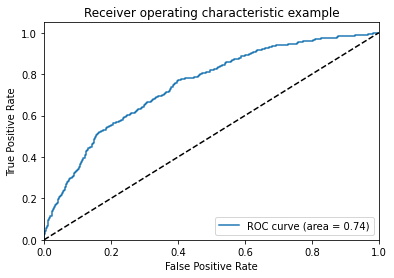

In [31]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


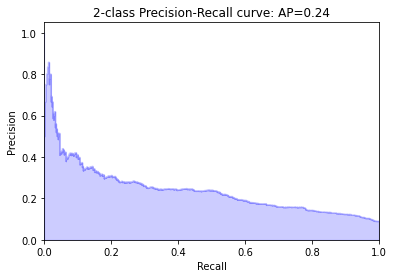

In [32]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.24')

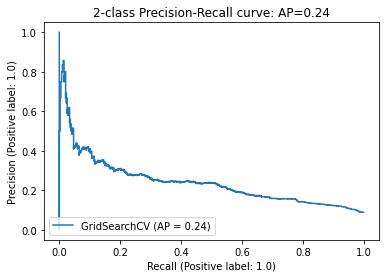

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score


average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = plot_precision_recall_curve(clf, X_test_std, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


In [34]:
from sklearn.ensemble import RandomForestClassifier


clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid={
        "n_estimators": [100, 200, 500, 1000],
        "max_depth": [10, 20, 50],
        "max_features": ["auto", "sqrt", "log2"],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=2,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters set found on development set:

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 1000}

Grid scores on development set:

0.745 (+/-0.028) for {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.753 (+/-0.023) for {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
0.756 (+/-0.021) for {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}
0.758 (+/-0.021) for {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000}
0.745 (+/-0.028) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.753 (+/-0.023) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
0.756 (+/-0.021) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
0.758 (+/-0.021) for {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.747 (+/-0.026) for {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.751 (+/-0.021) for {'max_depth': 

/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


In [ ]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


In [ ]:
from xgboost import XGBClassifier


clf = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid={
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.1, 0.3, 0.5],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=2,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)


plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters set found on development set:

{'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}

Grid scores on development set:

0.744 (+/-0.039) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.742 (+/-0.027) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.744 (+/-0.038) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'adam'}
0.744 (+/-0.039) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (1,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.523 (+/-0.015) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (1,), 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.744 (+/-0.038) for {'activation'

/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

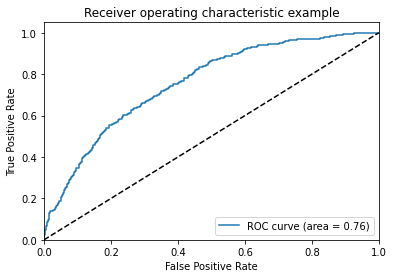

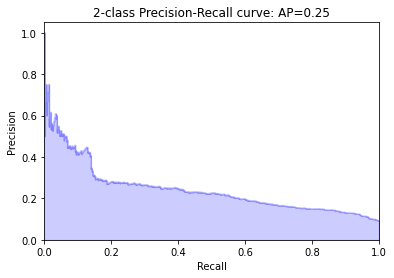

In [23]:
from sklearn.neural_network import MLPClassifier


clf = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid={
        "hidden_layer_sizes": [(2,), (2,3,), (2,3,5,), (2,5,3,), (3,), (3,5,), (5,3,), (5,), (10,), (20,)],
        "alpha": np.logspace(-5, 1, 5),
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=4,
    verbose=3,
)


clf.fit(X_train_std, y_train)



print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)


plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()
